# Import

In [1]:
import pandas as pd
import re
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, Normalizer #,power_transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_auc_score,classification_report, roc_curve, \
auc,accuracy_score, confusion_matrix, precision_score, log_loss, fbeta_score, \
recall_score, make_scorer, f1_score, precision_recall_curve


# Macros

In [2]:
DATA_FOLDER = '../../data/'
FIG_FOLDER = '../../figures/'

plt.style.use('seaborn-whitegrid')

# Utile Function

## Sklean Pipline Pandas support

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

# Prediction Model

## section data import 

In [4]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident_clean2.pkl')

## Medric / Score

### Model Metric - main assumtions

Main goal for business 
* Specificity / Selectivity
* try to avoid FP but also get TN right 
* the assumption that you will always find members/borrowers 
* investors are viewer and need to get investment reasons - no FP 

Prediction verfication:
* propabuilty is needed for risk assement
* the estimate must represent simmiler entropy then ground truth 
* ground truth is not balanced 
* --> cross entropy loss is taken in account to give indication

### Model Performance Overview function

In [5]:
def entropy_c(y):
    p = np.sum(y)/ len(y)
    pm = 1.-p
    return -(p*np.log(p))-(pm*np.log(pm))
                          
def entropy(y):
    return -((np.sum(y)/ len(y))*np.log(np.sum(y)/ len(y)))
                          
def rate(y):
    return np.sum(y)/ len(y)
    
def Model_Vali(m, X_train, X_test, y_train, y_test, thres=0.5):
    
    
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    y_base = np.ones(len(X_test))
    y_base0 = np.zeros(len(X_test))
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]
        if thres!=0.5:

            y_ins_pred = [1. if e > thres else 0. for e in y_ins_pred_p]
            y_outs_pred = [1. if e > thres else 0. for e in y_outs_pred_p]
    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
    
    print(f'train pred. rate = {rate(y_ins_pred)}' )
    print(f'train truth rate = {rate(y_train)}' )
    print(f'train truth entropy = {entropy_c(y_train)}' )
    print(f'train pred. entropy = {entropy_c(y_ins_pred)}' )
    print(f'test  pred. rate = {rate(y_outs_pred)}' )
    print(f'test  truth rate = {rate(y_test)}' )
    print(f'test  truth entropy = {entropy_c(y_test)}' )
    print(f'test  pred. entropy = {entropy_c(y_outs_pred)}' )
    
    
    print('--')
    print(f'base  recall = {recall_score(y_test, y_base)}')
    print(f'test  recall = {recall_score(y_test, y_outs_pred)}')
    print(f'train recall = {recall_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base0  precision = {precision_score(y_test, y_base0)}')
    print(f'base  precision = {precision_score(y_test, y_base)}')
    print(f'test  precision = {precision_score(y_test, y_outs_pred)}')
    print(f'train precision = {precision_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  ROC-AUC = {roc_auc_score(y_test, y_base)}')
    print(f'test  ROC-AUC = {roc_auc_score(y_test, y_outs_pred)}')
    print(f'train ROC-AUC = {roc_auc_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  accuracy = {accuracy_score(y_test, y_base)}')
    print(f'test  accuracy = {accuracy_score(y_test, y_outs_pred)}')
    print(f'train accuracy = {accuracy_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  log_loss = {log_loss(y_test, y_base)}')
    print(f'test  log_loss = {log_loss(y_test, y_outs_pred_p)}')
    print(f'train log_loss = {log_loss(y_train, y_ins_pred_p)}')
    print('--')
    print(f'base  TNR = {TNR(y_test, y_base)}')
    print(f'test  TNR = {TNR(y_test, y_outs_pred)}')
    print(f'train TNR = {TNR(y_train, y_ins_pred)}')
    

    print('--')
    cm = pd.DataFrame(confusion_matrix(y_test, y_outs_pred), 
                 index=[['actual', 'actual'], ['neg', 'pos']], 
                 columns=[['predicted', 'predicted'], ['neg', 'pos']])
    print('confusion matrix of test')
    display(cm)
    print('--')
    print(classification_report(y_test, y_outs_pred)) 
    
    base_fpr, base_tpr, base_tresh = roc_curve(y_test, y_base)
    test_fpr, test_tpr, test_tresh = roc_curve(y_test, y_outs_pred_p)
    train_fpr, train_tpr, train_tresh = roc_curve(y_train, y_ins_pred_p)
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(test_fpr, test_tpr, 'r', label = 'model-test')
    plt.plot(train_fpr, train_tpr, 'g', label = 'model-train')
    plt.plot(train_fpr, train_tresh, 'k--', label = 'thresh')
    print(len(train_tresh))
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

In [6]:
def entropy_c(y):
    p = np.sum(y)/ len(y)
    pm = 1.-p
    return -(p*np.log(p))-(pm*np.log(pm))
                          
def entropy(y):
    return -((np.sum(y)/ len(y))*np.log(np.sum(y)/ len(y)))
                          
def rate(y):
    return np.sum(y)/ len(y)
    
def Model_Vali_Rec(m, X_train, X_test, y_train, y_test, df , name ,thres=0.5):
    fbeta=0.5
    
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    y_base = np.ones(len(X_test))
    y_base0 = np.zeros(len(X_test))
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]
        if thres!=0.5:

            y_ins_pred = [1. if e > thres else 0. for e in y_ins_pred_p]
            y_outs_pred = [1. if e > thres else 0. for e in y_outs_pred_p]
    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
        
    
    df.at['base  recall', name] = recall_score(y_test, y_base)
    df.at['test  recall', name] = recall_score(y_test, y_outs_pred)
    df.at['train recall', name] = recall_score(y_train, y_ins_pred)
    
    df.at['base  precision', name] = precision_score(y_test, y_base)
    df.at['test  precision', name] = precision_score(y_test, y_outs_pred)
    df.at['train precision', name] = precision_score(y_train, y_ins_pred)
   
    df.at['base  ROC-AUC', name] = roc_auc_score(y_test, y_base)
    df.at['test  ROC-AUC', name] = roc_auc_score(y_test, y_outs_pred)
    df.at['train ROC-AUC', name] = roc_auc_score(y_train, y_ins_pred)
    
    df.at['base  f1', name] = f1_score(y_test, y_base)
    df.at['test  f1', name] = f1_score(y_test, y_outs_pred)
    df.at['train f1', name] = f1_score(y_train, y_ins_pred)
    
    df.at[f'base  fb={fbeta}', name] = fbeta_score(y_test, y_base,fbeta)
    df.at[f'test  fb={fbeta}', name] = fbeta_score(y_test, y_outs_pred, fbeta)
    df.at[f'train fb={fbeta}', name] = fbeta_score(y_train, y_ins_pred, fbeta)
    
    df.at['base  accuracy', name] = accuracy_score(y_test, y_base)
    df.at['test  accuracy', name] = accuracy_score(y_test, y_outs_pred)
    df.at['train accuracy', name] = accuracy_score(y_train, y_ins_pred)
    
    df.at['base  log loss', name] = log_loss(y_test, y_base)
    df.at['test  log loss', name] = log_loss(y_test, y_outs_pred_p)
    df.at['train log loss', name] = log_loss(y_train, y_ins_pred_p)
    
    df.at['train rate truth', name] = rate(y_train)
    df.at['test  rate truth', name] = rate(y_test)
    
    df.at['train rate pred.', name] = rate(y_ins_pred)
    df.at['test  rate pred.', name] = rate(y_outs_pred)
    
    df.at['train entopy truth', name] = entropy_c(y_train)
    df.at['test  entopy truth', name] = entropy_c(y_test)
    
    df.at['train entopy pred.', name] = entropy_c(y_ins_pred)
    df.at['test  entopy pred.', name] = entropy_c(y_outs_pred)
    
    cm = confusion_matrix(y_test, y_outs_pred)
    
    df.at['TN - good', name] = cm[0,0]
    df.at['TP - bad', name] = cm[1,1]
    df.at['FP - lost', name] = cm[0,1]
    df.at['FN - missed', name] = cm[1,0]

    
    base_fpr, base_tpr, base_tresh = roc_curve(y_test, y_base)
    test_fpr, test_tpr, test_tresh = roc_curve(y_test, y_outs_pred_p)
    train_fpr, train_tpr, train_tresh = roc_curve(y_train, y_ins_pred_p)
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(test_fpr, test_tpr, 'r', label = 'model-test')
    plt.plot(train_fpr, train_tpr, 'g', label = 'model-train')
    plt.plot(train_fpr, train_tresh, 'k--', label = 'thresh')
    #print(len(train_tresh))
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
    
    
    base_fpr, base_tpr, base_tresh = precision_recall_curve(y_test, y_base)
    test_fpr, test_tpr, test_tresh = precision_recall_curve(y_test, y_outs_pred_p)
    train_fpr, train_tpr, train_tresh = precision_recall_curve(y_train, y_ins_pred_p)
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(test_fpr, test_tpr, 'r', label = 'model-test')
    plt.plot(train_fpr, train_tpr, 'g', label = 'model-train')
    plt.plot(train_fpr[1:], train_tresh, 'k--', label = 'thresh')
    #print(len(train_tresh))
    plt.legend();
    plt.xlabel('precision'); 
    plt.ylabel('recall'); plt.title('precision recall curve');
    plt.show();
    
    

### Model Performance Overview function - short

In [7]:
def Model_Vali_short(m, X_train, X_test, y_train, y_test, thres=0.5, cm_print=False):
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    y_base = np.ones(len(X_test))
    y_base0 = np.zeros(len(X_test))
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]
        if thres!=0.5:

            y_ins_pred = [1. if e > thres else 0. for e in y_ins_pred_p]
            y_outs_pred = [1. if e > thres else 0. for e in y_outs_pred_p]
    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
        
    print(f'base1 log_loss = {log_loss(y_test, y_base)}')
    print(f'base0 log_loss = {log_loss(y_test, y_base0)}')
    print(f'test  log_loss = {log_loss(y_test, y_outs_pred_p)}')
    print(f'train log_loss = {log_loss(y_train, y_ins_pred_p)}')
    print('--')
    print(f'base1 TNR = {TNR(y_test, y_base)}')
    print(f'base0 TNR = {TNR(y_test, y_base0)}')
    print(f'test  TNR = {TNR(y_test, y_outs_pred)}')
    print(f'train TNR = {TNR(y_train, y_ins_pred)}')
    
    if cm_print:
        cm = pd.DataFrame(confusion_matrix(y_test, y_outs_pred), 
                 index=[['actual', 'actual'], ['neg', 'pos']], 
                 columns=[['predicted', 'predicted'], ['neg', 'pos']])
        
        print('confusion matrix of test')
        display(cm)
    

### Core Score function 

In [8]:
def TNR(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[0, 0] / \
    (confusion_matrix(y_true, y_pred)[0, 1]+confusion_matrix(y_true, y_pred)[0, 0])

def re(y_true, y_pred):
    return recall_score(y_true, y_pred)

def ll(y_true, y_pred):
    return log_loss(y_true, y_pred)

def special_PPV(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred)[1, 1] / \
    (confusion_matrix(y_true, y_pred)[0, 1]*100+confusion_matrix(y_true, y_pred)[1, 1])

## Preprocessing

### feature selection and marking

In [9]:
## All possible features
x_col_all = [
'addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status',
 'emp_ident']

# Target
y_col = ['target']

## Taken in account features
x_col_select = [
'dti',
'addr_state',
'term',
'annual_inc',
'loan_amnt',
'purpose',
'pub_rec',
'verification_status']
x_col_select = x_col_all
## Taken in account features
df_x = df[x_col_select]
df_y = df[y_col]

In [10]:
df.pub_rec.value_counts()

0.0    36562
1.0     2052
2.0       59
3.0       10
4.0        2
5.0        1
Name: pub_rec, dtype: int64

### Encoding - dummy cration

In [11]:
df_x_encoded = pd.get_dummies(df_x, drop_first=True)
#for i in df_x_encoded.columns:
#    print(i)
df_x_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38686 entries, 1 to 42474
Data columns (total 79 columns):
annual_inc                             38686 non-null float64
dti                                    38686 non-null float64
emp_length                             38686 non-null float64
loan_amnt                              38686 non-null float64
open_acc                               38686 non-null float64
pub_rec                                38686 non-null float64
pub_rec_bankruptcies                   38686 non-null int64
addr_state_AL                          38686 non-null uint8
addr_state_AR                          38686 non-null uint8
addr_state_AZ                          38686 non-null uint8
addr_state_CA                          38686 non-null uint8
addr_state_CO                          38686 non-null uint8
addr_state_CT                          38686 non-null uint8
addr_state_DC                          38686 non-null uint8
addr_state_DE                          

### Toggel the truth

In [12]:
df_y = ~df_y.astype('bool')
df_y = df_y.astype('float')

### Train Test Split

,train,test,all
0.0,0.849778,0.849733,0.849765
1.0,0.150222,0.150267,0.150235


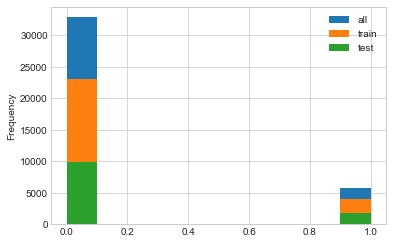

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df_x_encoded, df_y, test_size=0.3, random_state=25, stratify=df_y)

df_y.target.plot.hist()
y_train.target.plot.hist()
y_test.target.plot.hist()
plt.legend(['all','train','test'])
tts_df = pd.DataFrame()
tts_df['train'] = (y_train.target.value_counts()/y_train.shape[0])
tts_df['test'] = (y_test.target.value_counts()/y_test.shape[0])
tts_df['all'] = (df_y.target.value_counts()/df_y.shape[0])
tts_df

### Transform and Scaling Pipline

#### simple preproc pipline

In [14]:
preprocess_pipeline_1 = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector('float64'),
            StandardScaler()
        )),
        ("bool_features", make_pipeline(
            TypeSelector('int64'),
        )),
        ("dummy_features", make_pipeline(
            TypeSelector('uint8'),
        )),
    ]))

#### indvitual tranform pipline

In [15]:
# print the scalabels 
print(df_x_encoded.select_dtypes('float').columns)
print(df_x_encoded.select_dtypes('int64').columns)

Index(['annual_inc', 'dti', 'emp_length', 'loan_amnt', 'open_acc', 'pub_rec'], dtype='object')
Index(['pub_rec_bankruptcies'], dtype='object')


In [16]:
preprocess_pipeline_2 = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list= [
        ("sel_1",
        make_pipeline(ColumnSelector(columns=['dti' , 'loan_amnt']),
                     FunctionTransformer(lambda x:x),
                     StandardScaler()
                     )),
        ("sel_2",
        make_pipeline(ColumnSelector(columns=['annual_inc']),
                     FunctionTransformer(np.log),
                     MinMaxScaler()
                     )),
        ("sel_3",
        make_pipeline(ColumnSelector(columns=['pub_rec' , 'emp_length', 'open_acc']),
                     FunctionTransformer(lambda x:x),
                     MinMaxScaler()
                     )),
        ("bool_features", 
            make_pipeline(TypeSelector('int64'),
        )),
        ("dummy_features", 
             make_pipeline(TypeSelector('uint8'),
        )),
        ])
        )

In [17]:
t =preprocess_pipeline_2.fit_transform(X_train)
print(t.shape)
print(X_train.shape)

(27080, 79)
(27080, 79)


## Different Models

### Baseline: Logistics Regression

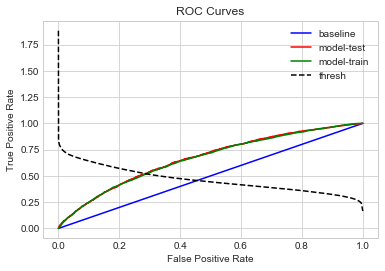

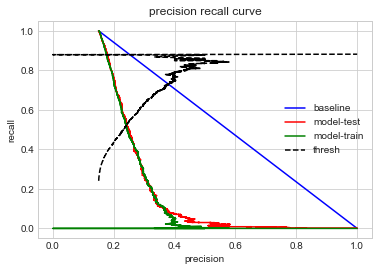

In [18]:
df_model_comp = pd.DataFrame()
m1_pipline=Pipeline([('pre',preprocess_pipeline_2), ('M',LogisticRegression(C=0.03, class_weight='balanced' ))])
m1_pipline.fit(X_train,y_train.values.ravel())
Model_Vali_Rec(m1_pipline, X_train, X_test, y_train.values, y_test.values, df_model_comp, 'log reg 1')


In [19]:
#df_model_comp

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.5min finished
/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


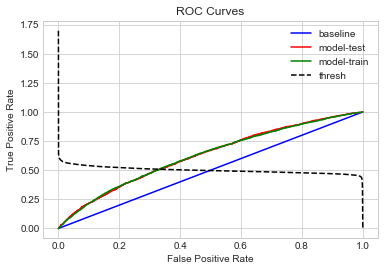

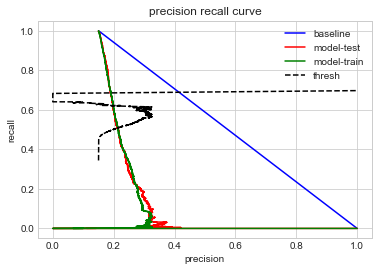

In [20]:
mg_pipline=Pipeline([('pre',preprocess_pipeline_1), ('M',LogisticRegression(class_weight='balanced'))])

param_grid = [
    
    {'pre': [preprocess_pipeline_2,preprocess_pipeline_1],
     'M' : [LogisticRegression()],
     'M__penalty' : ['l2', 'elasticnet'],
     'M__C' : np.logspace(-4, 4, 20),
     'M__solver' : ['liblinear'],
     'M__class_weight' : ['balanced', None]}]

GSM = GridSearchCV(
    mg_pipline, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1 ,scoring=make_scorer(re))

GSM.fit(X_train,y_train)

Model_Vali_Rec(GSM, X_train, X_test, y_train.values, y_test.values, df_model_comp, 'log reg grid')

In [22]:
#GSM.fit(X_train,y_train)
df_model_comp

,log reg 1,log reg grid
base recall,1.000000,1.000000
test recall,0.573394,0.629587
train recall,0.565634,0.626352
base precision,0.150267,0.150267
test precision,0.233427,0.196951
train precision,0.231745,0.198551
base ROC-AUC,0.500000,0.500000
test ROC-AUC,0.620200,0.587811
train ROC-AUC,0.617077,0.589706
base f1,0.261273,0.261273


In [ ]:
### Stackling

### Naive Bayes

### Gradient Boost